# How does $z$-projection of 3D distributions (as in aster) affect appearent shapes?
`{aduarte,gsalmon}@caltech.edu`

In [1]:
## IMPORTS
import pandas as pd
import numpy as np
import h5py
import glob

######### gabe hacky styling to emulate some of PBoC Phillips lab style conventions, however hacky. tries to make easier for nigel++
## Styling
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
# sns.set_style('ticks')

import matplotlib.colors as c
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set the property to save figures with text as text, not paths
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# default good PBoC colors
baseBlendColor=(224/255, 219/255, 209/255,1) # default background for plots
contrastColor=(209/255, 193/255, 171/255,1) # slightly darker tan for contrasts, e.g. in inset boxes
yellowTanHighlightBoxColor='#FEF0C6'
goodGreyGreenArrowColor='#CCD4C9'

### Griffin style invocation

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.path import Path
from matplotlib.patches import BoxStyle
from matplotlib.offsetbox import AnchoredText

def plotting_style(grid=False):
    """
    Sets the style to the publication style. To instantiate, simply call
    plotting_style() at the beginning of your script or notebook to force
    all matplotlib plots to adopt the scheme.

    Parameters
    ----------
    grid: bool
      If True, plots will have a thin, white grid in the background. Default
      is False.

    Returns
    -------
    colors: dict
      Returns a dictionary of the standard PBoC 2e color palette.
    """
    rc = {'axes.facecolor': '#E3DCD0',
#               'axes.spines.top': False,
#               'axes.spines.right': False,
#               'axes.spines.left': False,  # Ensure left spine is present
#               'axes.spines.bottom': False,  # Ensure bottom spine is present
#               'axes.spines.left': False, #{'color': '#E3DCD0', 'linewidth': 1.5},  # Set the spine color to the background color
#               'axes.spines.bottom': False, #{'color': '#E3DCD0', 'linewidth': 1.5},  # Set the spine color to the background color
          #'font.family': '/usr/share/fonts/truetype/LucidaSansOT.otf', #'LucidaSansOT.otf',
          'grid.linestyle': '-',
          'grid.linewidth': 0.5,
          'grid.alpha': 0.75,
          'grid.color': '#ffffff',
          'axes.grid': grid,
          'ytick.direction': 'in',
          'xtick.direction': 'in',
          'xtick.gridOn': grid,
          'ytick.gridOn': grid,
#               'ytick.major.width':8,
#               'xtick.major.width':8,
#               'ytick.major.size': 8,
#               'xtick.major.size': 8,
          'mathtext.fontset': 'stixsans',
          'mathtext.sf': 'sans',
          'legend.frameon': True,
          'legend.facecolor': '#FFEDCE',
          'figure.dpi': 150,
          'xtick.color': 'k',
          'ytick.color': 'k'
         }
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('mathtext', fontset='stixsans', sf='sans')
    sns.set_style('darkgrid', rc=rc)
    return color_palette()

def color_palette():
    """
    Returns a dictionary of the PBOC color palette
    """
    return {'green': '#7AA974', 'light_green': '#BFD598',
              'pale_green': '#DCECCB', 'yellow': '#EAC264',
              'light_yellow': '#F3DAA9', 'pale_yellow': '#FFEDCE',
              'blue': '#738FC1', 'light_blue': '#A9BFE3',
              'pale_blue': '#C9D7EE', 'red': '#D56C55', 'light_red': '#E8B19D',
              'pale_red': '#F1D4C9', 'purple': '#AB85AC',
              'light_purple': '#D4C2D9', 'dark_green':'#7E9D90', 'dark_brown':'#905426'}

def titlebox(
    ax, text, color, bgcolor=None, size=8, boxsize=0.1, pad=0.05, **kwargs
):
    """
    Sets a colored title box above the plot, spanning the entire plot width.

    Parameters
    ----------
    ax : matplotlib axis object
      The axis on which you want to add the titlebox.
    text: str
      The title tect
    bgcolor: str or None
      The background color of the title box. Default is no color (blank).
    size:  int
      Size of the text font
    boxsize: float [0, 1]
      Fraction of the total plot height to be occupied by the box. Default is 10% (0.1).
    pad: float
      The padding space between the title box and the top of the plot.

    """
    boxsize=str(boxsize * 100)  + '%'
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size=boxsize, pad=pad)
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.spines["top"].set_visible(False)
    cax.spines["right"].set_visible(False)
#     cax.spines["bottom"].set_visible(False)
#     cax.spines["left"].set_visible(False)

#     cax.spines["bottom"].set_visible(True)
#     cax.spines["left"].set_visible(True)
#     cax.spines["left"].set_color("white")
#     cax.spines["bottom"].set_color("white")
#     cax.spines["bottom"].set_color("white")

#     cax.set_ticks_position('both')  # Adding ticks to both top and bottom
#     cax.yaxis.set_tick_params(direction='in', which='both', color='white')  # The bottom will maintain the default of 'out'


    plt.setp(cax.spines.values(), color=color)
    if bgcolor != None:
        cax.set_facecolor(bgcolor)
    else:
        cax.set_facecolor("white")
    at = AnchoredText(text, loc=10, frameon=False, prop=dict(size=size, color=color))
    cax.add_artist(at)


### Now actually call it
plotting_style()

import matplotlib.patheffects as pe
matplotlib.rcParams['axes.autolimit_mode'] = 'data'

### Test distribution
* Assume motors are spherically-symmetrically distributed in a gradient $c(r)$,
$$c(r) = c_0 \exp[-r/\lambda]. $$ 
For now, measure concentrations in scales of $c_0$ and lengths in units of $\lambda$, giving nondimensionalized,
$$c(r) = \exp[-r].$$
* Note that $r^2 = z^2 + y^2 + x^2$. Let $\rho:= \sqrt{x^2 + y^2}.$ So, $r^2 = z^2 + \rho^2.$ This means that $2r ~dr/dz = 2z$ and thus $dz = \frac{r}{z}~dr$.
* Optical projection gives,
\begin{align}
\hat{c}(\rho) & := \int_{z=-\infty}^\infty dz~ c(z,\rho) = 2 \int_{z=0}^\infty dz~ c(z,\rho) \\
& = 2\int dz~c(r)\\
& = 2\int dr \frac{r}{z} c(r) ~dr\\
& = \boxed{2\int_{r=\rho}^\infty dr \frac{r}{\sqrt{r^2 - \rho^2}} c(r)}.
\end{align}
where we used the symmetry of the distribution about $z=0$, and in the last step, the value of $r$ varies from $\rho$ (the case when $z=0$) to $\infty$ (the case when $z=\infty$).

### First, obviously confirm a few properties of the underlying spherical distribution,

Text(0.5, 0, 'radial coordinate $r$')

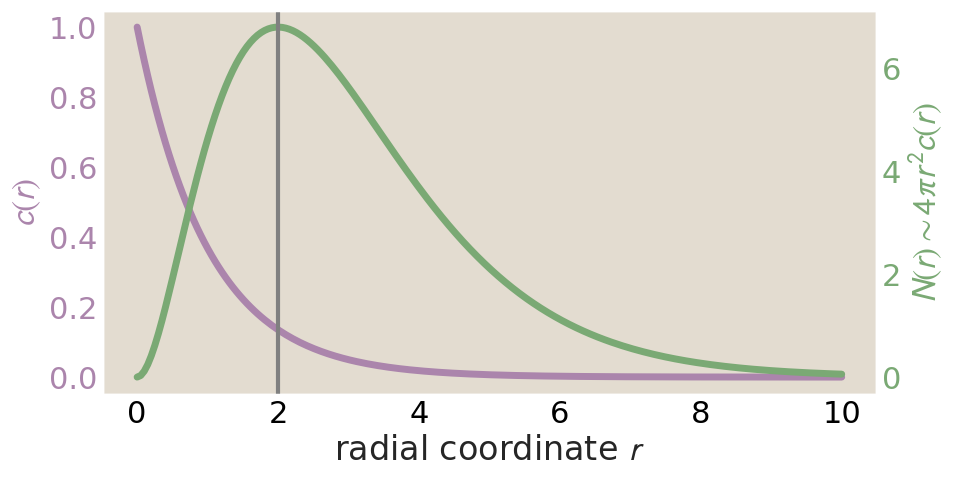

In [2]:

rVals=np.linspace(0, 10, 200)
motConcs=np.exp(-rVals)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(rVals, motConcs, lw=5, color=color_palette()['purple'])
ax2=ax.twinx()
ax2.plot(rVals, motConcs*4*np.pi*rVals**2, lw=5, color=color_palette()['green'])

# Set y-axis tick labels to the specified font color
plt.setp(ax.get_yticklabels(), color=color_palette()['purple'])
ax.tick_params(axis='y', which='both', length=0) # Hide the y-axis tick lines
ax.set_ylabel(r'$c(r)$', color=color_palette()['purple'])

plt.setp(ax2.get_yticklabels(), color=color_palette()['green'])
ax2.tick_params(axis='y', which='both', length=0)
ax2.set_ylabel(r'$N(r)\sim 4\pi r^2 c(r)$', color=color_palette()['green'])
plt.axvline(2, color='grey')

ax.set_xlabel('radial coordinate $r$')

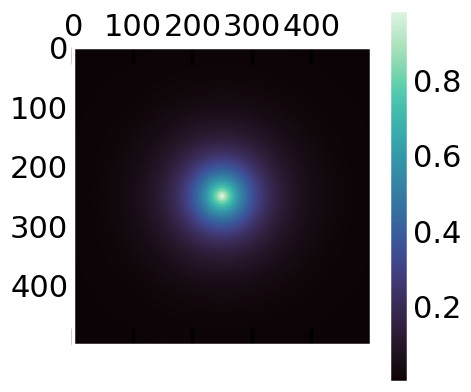

In [3]:
### simple slice
xVals=np.linspace(0,10,500)-5
yVals=np.linspace(0,10,500)-5
X, Y = np.meshgrid(xVals, yVals)
r_z0 = np.sqrt(X**2 + Y**2) # at z=0
C=np.exp(-r_z0)

plt.matshow(C, cmap=sns.color_palette('mako', as_cmap=True))
plt.colorbar()

Text(0.5, 1.0, 'proxy for number')

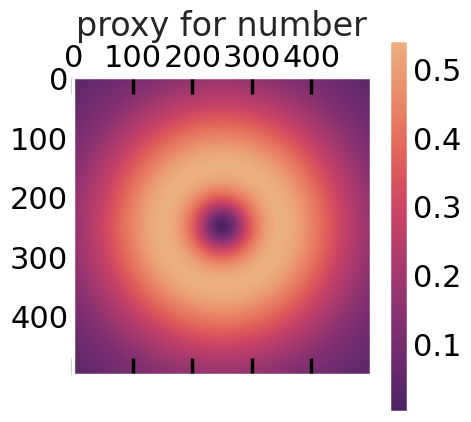

In [59]:
### simple slice
xVals=np.linspace(0,10,500)-5
yVals=np.linspace(0,10,500)-5
X, Y = np.meshgrid(xVals, yVals)
r_z0 = np.sqrt(X**2 + Y**2) # at z=0
C=np.exp(-r_z0)

plt.matshow(C*r_z0**2, cmap=sns.color_palette('flare_r', as_cmap=True))
plt.colorbar()
plt.title('proxy for number')
#plt.ticks('off')

# Super simple model what this looks like under projection.

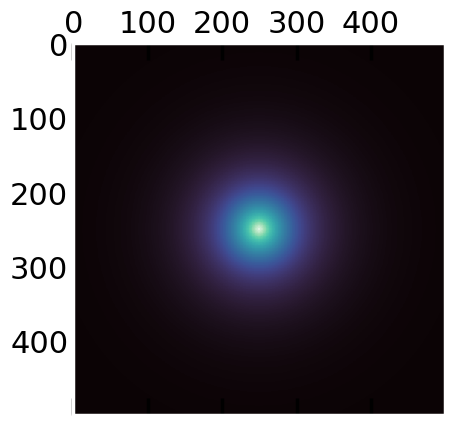

In [4]:
# perform numerical integral...
import scipy

def getProj(rho, cRfunct=lambda r: np.exp(-r)):
    result, error = scipy.integrate.quad(cRfunct, rho, np.inf)
    return 2*result

rhoBinEdgeVals=np.linspace(1e-3, 10, num=1000+1)
rhoMidVals=(rhoBinEdgeVals[:-1]+rhoBinEdgeVals[1:])/2
projCvalsForRho=[getProj(rho) for rho in rhoMidVals]

## Iteratively build up
projMap=np.zeros_like(C)
for ii in range(len(rhoMidVals)):
    # find the iith rho-radial annulus
    annulusMask=(r_z0 >= rhoBinEdgeVals[ii]) & (r_z0 < rhoBinEdgeVals[ii+1])
   # plt.matshow(annulusMask)
    projMap=projMap+annulusMask*projCvalsForRho[ii]

plt.matshow(projMap, cmap=sns.color_palette('mako', as_cmap=True))

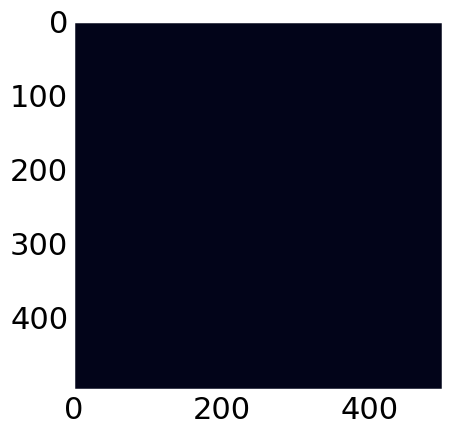

In [5]:
plt.imshow(annulusMask)

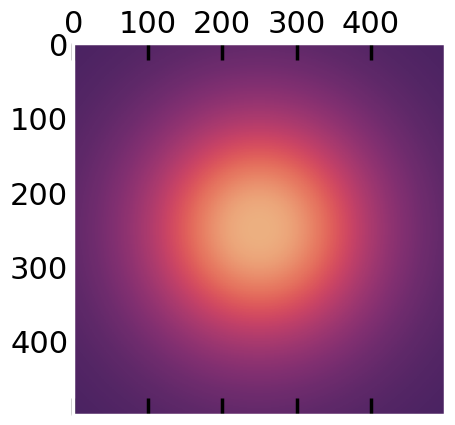

In [74]:
# perform numerical integral...FOR NUMBER
import scipy

def getProj_num(rho, cRfunct=lambda r: 4*np.pi*r**2*np.exp(-r)):
    result, error = scipy.integrate.quad(cRfunct, rho, np.inf)
    return 2*result

rhoBinEdgeVals=np.linspace(1e-3, 10, num=1000+1)
rhoMidVals=(rhoBinEdgeVals[:-1]+rhoBinEdgeVals[1:])/2
projCvalsForRho_num=[getProj_num(rho) for rho in rhoMidVals]

## Iteratively build up
projMap_Num=np.zeros_like(C)
for ii in range(len(rhoMidVals)):
    # find the iith rho-radial annulus
    annulusMask=(r_z0 >= rhoBinEdgeVals[ii]) & (r_z0 < rhoBinEdgeVals[ii+1])
   # plt.matshow(annulusMask)
    projMap_Num=projMap+annulusMask*projCvalsForRho_num[ii]

plt.matshow(projMap_Num, cmap=sns.color_palette('flare_r', as_cmap=True))

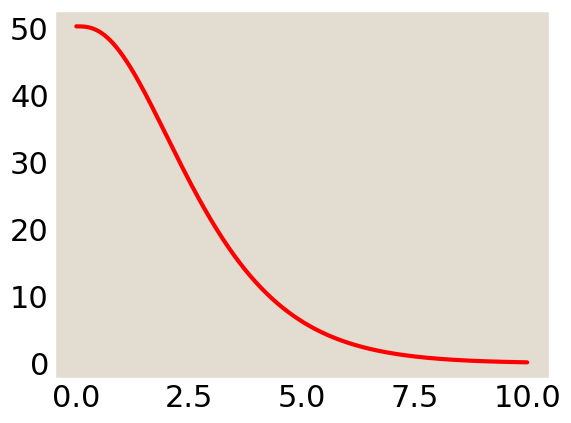

In [75]:
plt.plot(rhoMidVals, projCvalsForRho_num, 'r-')

Text(0.5, 1.0, 'approximate projection map')

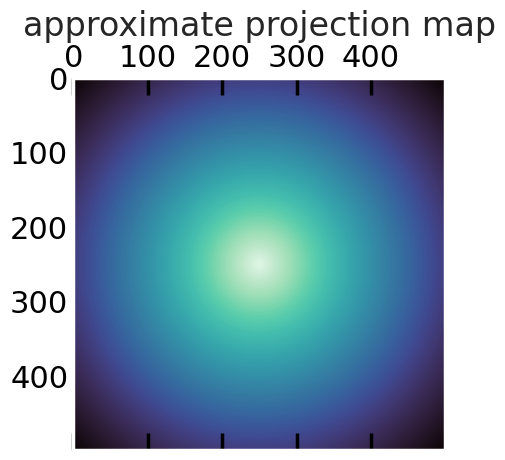

In [67]:
#### Visualize the raw transformation function itself, assuming c(r) were uniform!
# perform numerical integral...
import scipy

def getProj(rho, cRfunct=lambda r: 1):
    result, error = scipy.integrate.quad(cRfunct, rho, 1000000)
    return 2*result

rhoBinEdgeVals=np.linspace(1e-3, 10, num=1000+1)
rhoMidVals=(rhoBinEdgeVals[:-1]+rhoBinEdgeVals[1:])/2
projCvalsForRho=[getProj(rho) for rho in rhoMidVals]

## Iteratively build up
projMap=np.zeros_like(C)
for ii in range(len(rhoMidVals)):
    # find the iith rho-radial annulus
    annulusMask=(r_z0 >= rhoBinEdgeVals[ii]) & (r_z0 < rhoBinEdgeVals[ii+1])
   # plt.matshow(annulusMask)
    projMap=projMap+annulusMask*projCvalsForRho[ii]

plt.matshow(projMap, cmap=sns.color_palette('mako', as_cmap=True))
plt.title("approximate projection map")

In [73]:
### It weirdly looks like the abel transform map is very powerful---it seems to overpower the effect in the original number distribution that, for small r, the volume of shells ~ r^2 is small ??
### 

# See if numerical abel inversion is apparently possible for this example

In [76]:
## install pyabel
import os
import sys

os.system(f'"{sys.executable}" -m pip install pyabel')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 3.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pyabel: filename=PyAbel-0.9.0-py3-none-any.whl size=155107 sha256=52833ae39e4303f0e4bc1341e3f593a46fc4fd32ab14da87fcbf009f84490a4f
  Stored in directory: /home/gsalmon/.cache/pip/wheels/c8/08/d0/961e562d7a2e378b3eb024734d63e8c41d88106c754f98eb54
Successfully built pyabel



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: /home/gsalmon/dedalus3/bin/python -m pip install --upgrade pip


0

In [78]:
### Run PyAbel on this mini example
import abel

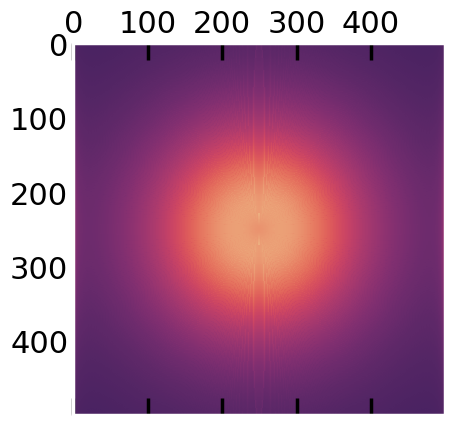

In [96]:
inverse_abel = abel.Transform(projMap_Num, direction='inverse',
                              method='three_point').transform
plt.matshow(inverse_abel, cmap=sns.color_palette('flare_r', as_cmap=True))

Falling back to a pure Python backend...
Falling back to a pure Python backend...
Falling back to a pure Python backend...
Falling back to a pure Python backend...


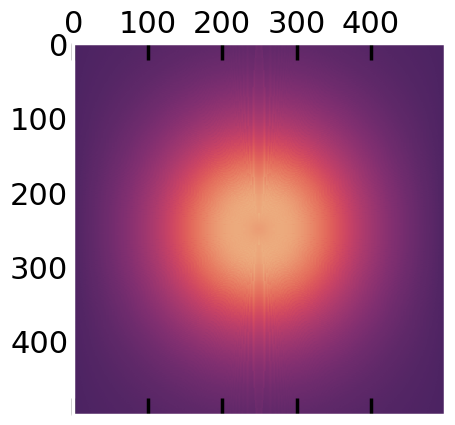

In [87]:
inverse_abel = abel.Transform(projMap_Num, direction='inverse',
                              method='direct').transform
plt.matshow(inverse_abel, cmap=sns.color_palette('flare_r', as_cmap=True))

Using memory-cached basis sets
Using memory-cached basis sets
Using memory-cached basis sets
Using memory-cached basis sets


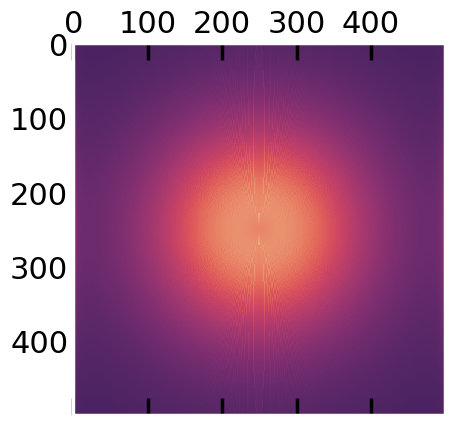

In [86]:
inverse_abel = abel.Transform(projMap_Num, direction='inverse',
                              method='basex').transform
plt.matshow(inverse_abel, cmap=sns.color_palette('flare_r', as_cmap=True))#, cmap='ocean_r')

Generating basis projections for n = 250, degree = 0...


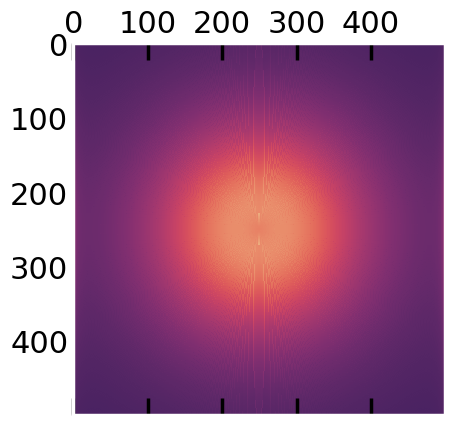

In [89]:
inverse_abel = abel.Transform(projMap_Num, direction='inverse',
                              method='daun').transform
plt.matshow(inverse_abel, cmap=sns.color_palette('flare_r', as_cmap=True))#, cmap='ocean_r')

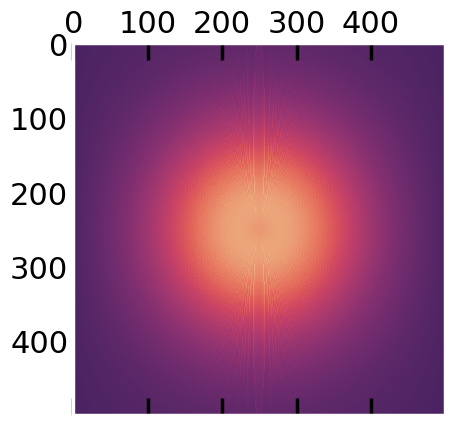

In [90]:
inverse_abel = abel.Transform(projMap_Num, direction='inverse',
                              method='hansenlaw').transform
plt.matshow(inverse_abel, cmap=sns.color_palette('flare_r', as_cmap=True))#, cmap='ocean_r')

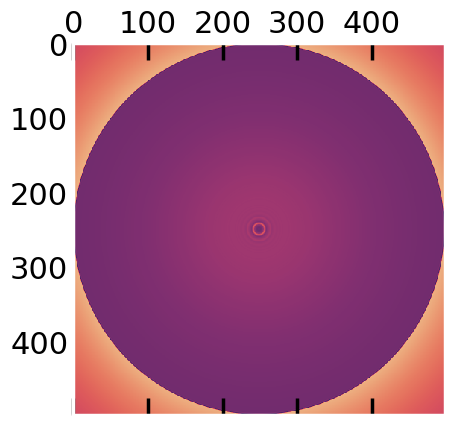

In [92]:
inverse_abel = abel.Transform(projMap_Num[:-1,:-1], direction='inverse',
                              method='linbasex').transform
plt.matshow(inverse_abel, cmap=sns.color_palette('flare_r', as_cmap=True))#, cmap='ocean_r')

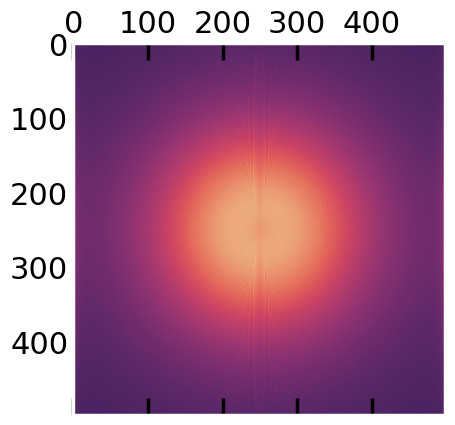

In [93]:
inverse_abel = abel.Transform(projMap_Num[:-1,:-1], direction='inverse',
                              method='onion_bordas').transform
plt.matshow(inverse_abel, cmap=sns.color_palette('flare_r', as_cmap=True))#, cmap='ocean_r')

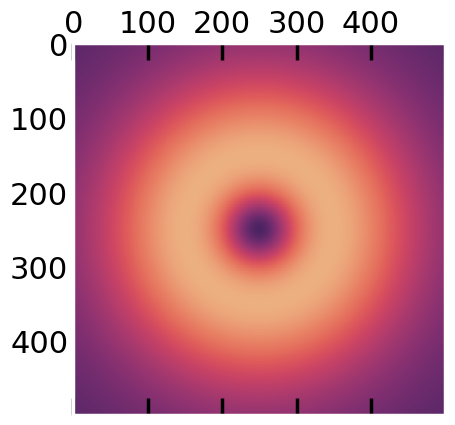

In [94]:
originalRawNumMap=4*np.pi*r_z0**2*np.exp(-r_z0)
plt.matshow(originalRawNumMap, cmap=sns.color_palette('flare_r', as_cmap=True))